<a href="https://colab.research.google.com/github/joris-vaneyghen/mss-jazz-playalong/blob/main/segmentation/cluster_segments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download our audio example
!git clone https://github.com/joris-vaneyghen/mss-jazz-playalong.git

Cloning into 'mss-jazz-playalong'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 175 (delta 91), reused 10 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (175/175), 40.66 MiB | 7.03 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [2]:
import numpy as np
import json
import os

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt


In [3]:
with open('mss-jazz-playalong/sound_classes_audioset.json', 'r') as f:
  sound_classes_audioset = json.load(f)

In [4]:
input_path = 'mss-jazz-playalong/examples'
output_path = 'mss-jazz-playalong/out/segment_and_tag'
resolution = 0.32 # resolution of EfficientAT model

In [36]:
def load_json(dir, mp3_file):
    # Replace .mp3 extension with .json
    json_file_name = mp3_file.replace('.mp3', '.json')
    file_path = os.path.join(dir, json_file_name)

    # Check if the .json file exists
    if not os.path.exists(file_path):
        return {}  # Return an empty dictionary if the .json file doesn't exist

    # Load the JSON file if it exists
    with open(file_path, 'r') as file:
        return json.load(file)

# def save_json(dir, mp3_file, data):
#     # Replace .mp3 extension with .json
#     json_file_name = mp3_file.replace('.mp3', '.json')
#     file_path = os.path.join(dir, json_file_name)

#     # Check if directory exists, create it if not
#     if not os.path.exists(dir):
#         os.makedirs(dir)

#     # Save the data to the .json file
#     with open(file_path, 'w') as file:
#         json.dump(data, file, indent=4)

def iterate_files(dir):
    for file_name in os.listdir(dir):
        if file_name.endswith('.mp3'):
            yield file_name


def calc_features(segment_preds, drums, bass, vocals):
  features = []
  for audio_class in sound_classes_audioset:
    if audio_class == 'drums':
      features.append(drums)
    elif audio_class == 'bass':
      features.append(bass)
    elif audio_class == 'vocals':
      features.append(vocals)
    else:
      audioset_indices = [ audio_set_cls['index'] for audio_set_cls in sound_classes_audioset[audio_class]]
      features.append(segment_preds[:, audioset_indices].sum(axis=1))

  # return np.array(features)
  return np.stack(features, axis=1)


In [8]:
segment_lengths =  []
segment_preds = []
drums = []
bass = []
other = []
vocals = []
for mp3_file in iterate_files(input_path):
  data = load_json(output_path, mp3_file)
  if ('demucs' in data.keys() and 'segments' in data.keys()):
    segments = data['segments']
    for segment in segments:
      length = segment['end_idx'] - segment['start_idx']
      segment_lengths.append(length)
      segment_preds.append(segment['preds'])
      drums.append(segment['drums'])
      bass.append(segment['bass'])
      other.append(segment['other'])
      vocals.append(segment['vocals'])



In [ ]:
# plot frequency chart of segment_lengths
plt.hist(segment_lengths, bins=20)
plt.xlabel("Segment Length")
plt.ylabel("Frequency")
plt.title("Frequency Chart of Segment Lengths")
plt.show()


In [37]:
segment_preds = np.array(segment_preds)
drums = np.array(drums)
bass = np.array(bass)
other = np.array(other)
vocals = np.array(vocals)
demucs_features = np.stack((drums, bass, vocals, other), axis=1)

In [38]:
features = calc_features(segment_preds, drums, bass, vocals);
features.shape

(216, 12)

In [48]:
# normalize features
normalized_features = (features - np.mean(features, axis=0, keepdims=True)) / np.std(features, axis=0, keepdims=True)

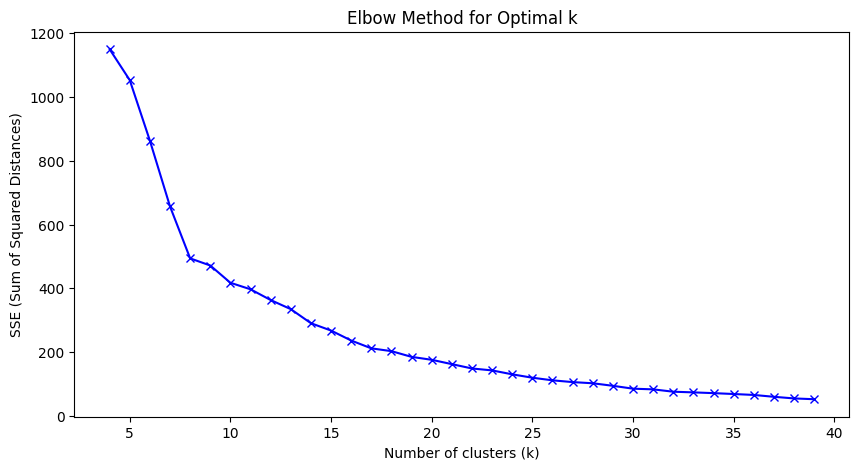

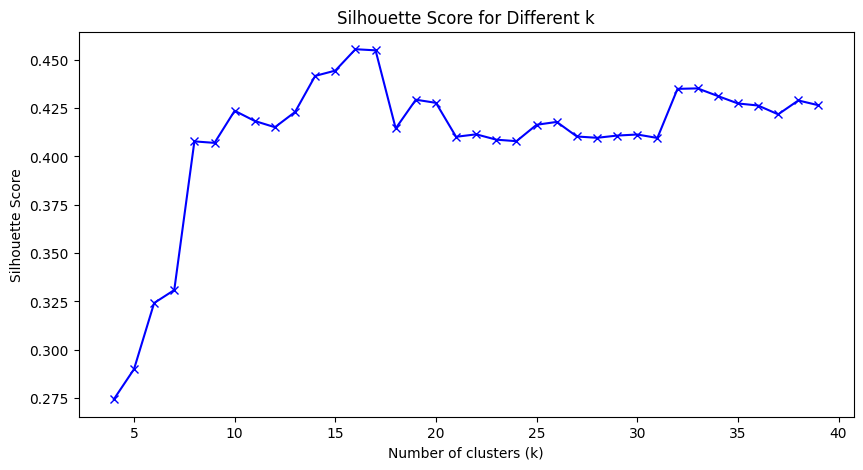

Best number of clusters: 16
Cluster labels for the data points: [15  6  6 15  2  2  8  8  2  8 12 14  6  6 12 13  6 13  4  4  4 12 13 13
 13 13 13  7 13 15  8  7  6  6  6  8  6 12  0  0  0 10 12 12 12 12 12  7
  3  3 12  3  3 12  3  3  3  3  3  3 12  3 12  7  3  3  3 12  3  3 12 12
 10 12  5  0  3  9  3  3  0  7  7  9  3 12 12 12  3  7  3  3 12 10 12 12
 12 12 12 12 12 12 12 12  3 12 12 12 12  3 14  3  3  3  3  3  0  1  0 12
 12  3  3  3  3  3  9  3  3  3  9 12 12 12 12  3 12 12  3  3  3  3  3  3
  7  3  9 12 12 12 12 12 12 12  0  1 12 12  9  9 12  3  3  3  3  9 12  9
  3  9  3 12  9  9  3  7  3 12  9  9  9  9  9  9 12  3 11  3  3  9 12  0
 12 12  3  3 12  3  9  3 12  3 12  3  3  3  3  9  3  3  9  3 12  0  0 12]


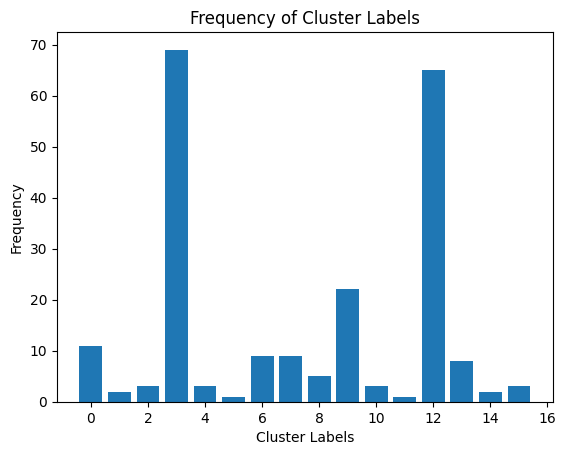

In [59]:
# Range of clusters to try (from 2 to 5)
cluster_range = range(4, 40)

# List to store SSE (sum of squared distances) for the elbow method
sse = []
silhouette_scores = []


# pca = PCA(n_components=20)  # Reduce to 50 dimensions or fewer


# combined = np.concatenate((segment_preds, demucs_features * 10 ), axis=1)
# data = pca.fit_transform(combined)
data = normalized_features

# Perform KMeans clustering for different values of k
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)  # SSE for elbow method
    silhouette_avg = silhouette_score(data, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot SSE for elbow method
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, sse, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Plot Silhouette Score for each k
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.show()

# Choose the best k based on visual inspection of the elbow and silhouette score
best_k = cluster_range[np.argmax(silhouette_scores)]
print(f"Best number of clusters: {best_k}")

# Perform KMeans clustering with the best k
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(data)

# Print cluster labels for each sample
print("Cluster labels for the data points:", labels)

unique_labels, label_counts = np.unique(labels, return_counts=True)

# Plot the frequencies of labels
plt.bar(unique_labels, label_counts)
plt.xlabel('Cluster Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Cluster Labels')
plt.show()


In [58]:
# for each clustercenter print largest dimensions. Use the dimension_names

dimension_names = [audio_class for  audio_class in sound_classes_audioset]

for i, cluster_center in enumerate(kmeans.cluster_centers_):
  top_indices = np.argsort(cluster_center)[::-1]  # Sort in descending order
  print(f"\nCluster {i + 1}: Top Dimensions")
  for j in range(5):  # Print top 5 dimensions
    dimension_index = top_indices[j]
    print(f"  {dimension_names[dimension_index]}: {cluster_center[dimension_index]:.4f}")



Cluster 1: Top Dimensions
  speech: 1.2039
  timekeeping_sound: 0.9433
  drums: 0.1610
  audience: 0.0345
  guitar: -0.0711

Cluster 2: Top Dimensions
  timekeeping_sound: 5.5563
  audience: 4.5406
  guitar: 3.7005
  speech: 3.4291
  wind_instrument: 1.4033

Cluster 3: Top Dimensions
  drums: 4.8944
  vocals: 3.6962
  bass: 1.9694
  environmental_noise: -0.1718
  piano: -0.1798

Cluster 4: Top Dimensions
  wind_instrument: 0.7664
  environmental_noise: -0.1650
  other_instrument: -0.1937
  piano: -0.1938
  speech: -0.2193

Cluster 5: Top Dimensions
  piano: 7.8500
  other_instrument: 0.4296
  environmental_noise: -0.1722
  audience: -0.2388
  timekeeping_sound: -0.2581

Cluster 6: Top Dimensions
  other_instrument: 11.1382
  environmental_noise: 8.4087
  audience: 5.5812
  speech: 5.2943
  guitar: 3.7037

Cluster 7: Top Dimensions
  vocals: 3.2930
  bass: 3.1761
  drums: 0.6854
  piano: -0.1596
  environmental_noise: -0.1696

Cluster 8: Top Dimensions
  wind_instrument: 1.9120
  other

In [ ]:
import pickle

# Save the PCA model to a file
def save_pca_model(pca, filename="pca_model.pkl"):
  with open(filename, "wb") as f:
    pickle.dump(pca, f)

# Load the PCA model from a file
def load_pca_model(filename="pca_model.pkl"):
  with open(filename, "rb") as f:
    return pickle.load(f)

# Project new data using the loaded PCA model
def transform_data(pca_model, new_data):
  return pca_model.transform(new_data)

def save_kmeans_model(kmeans, filename="kmeans_model.pkl"):
  with open(filename, "wb") as f:
    pickle.dump(kmeans, f)

# Load the KMeans model from a file
def load_kmeans_model(filename="kmeans_model.pkl"):
  with open(filename, "rb") as f:
    return pickle.load(f)

# Predict cluster labels for new data using the loaded KMeans model
def predict_cluster_labels(kmeans_model, new_data):
  return kmeans_model.predict(new_data)

# Example usage:

# Assuming 'pca' is your trained PCA model
save_pca_model(pca)

# Assuming 'kmeans' is your trained KMeans model
save_kmeans_model(kmeans)

# Later, to load and use the model:
loaded_pca = load_pca_model()

# Later, to load and use the model:
loaded_kmeans = load_kmeans_model()

# Example new data
new_data = np.random.rand(10, 531) # Replace with your actual new data

# Project the new data using the loaded PCA model
transformed_data = transform_data(loaded_pca, new_data)
print(transformed_data.shape)

# Predict the cluster labels for the new data
new_labels = predict_cluster_labels(loaded_kmeans, transformed_data)
print(new_labels)